# Set up

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

from nnn.uv import *

In [2]:
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

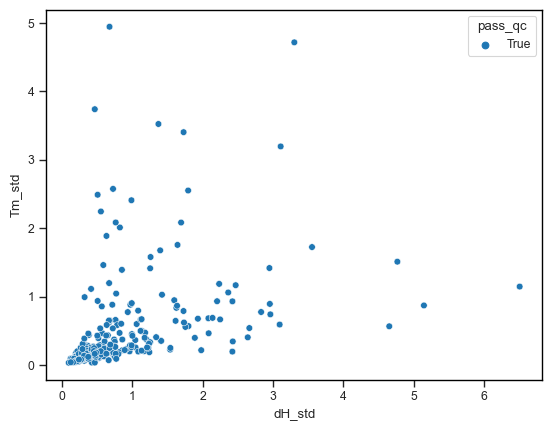

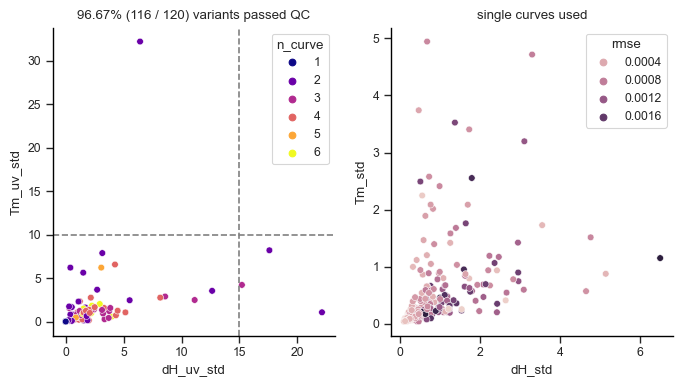

In [50]:
sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet230502.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_230502_2.csv'
agg_result_file='./data/uv_melt/uvmelt_agg_230907.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria='rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120',
                               Tm_std_thresh=10, dH_std_thresh=15,
                               sample_sheet_file=sample_sheet_file, 
                               clean=True, only_use_cooling=False)

result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

# Example UV melting curve

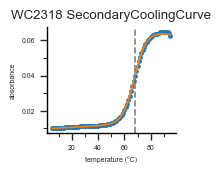

In [34]:
"""
for export
"""
df_2a = result_df.query('curve_date == 22071204 & curve_num == 7')
row = df_2a.iloc[0,:]
fn = row['data_file']
blanked_fn = get_blanked_fn(fn)
if os.path.isfile(blanked_fn):
    fn = blanked_fn
curve = read_curve(fn)
curve_predict = curve_model(curve.celsius, **{x:row[x] for x in ['dH','Tm','fmax','fmin','s1', 's2']})

fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))

row = df_2a.iloc[2,:]
ax.plot(curve.celsius, curve.absorbance, '.')
ax.plot(curve.celsius, 
         curve_predict - curve_predict[0] + curve.absorbance[0])
ax.axvline(row['Tm'], linestyle='--', c='gray')

ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))

ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)

ax.set_xlabel('temperature (°C)', fontsize=tick_font_size)
ax.set_ylabel('absorbance', fontsize=tick_font_size)

if 'SEQID' in row.index:
    plt.title('%s %s' % (row['SEQID'], row['curve_name']))
else:
    plt.title('%s' % (row['data_file']))
sns.despine()

util.save_fig('./fig/Fig2/Fig2a/UV_melting_example_curve_WC2318.pdf')

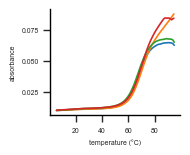

In [35]:
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
for _,row in df_2a.iterrows():
    curve = read_curve(get_blanked_fn(row['data_file']))
    # curve_predict = curve_model(curve.celsius, **{x:row[x] for x in ['dH','Tm','fmax','fmin','s1', 's2']})
    ax.plot(curve.celsius, curve.absorbance)
    
ax.xaxis.set_major_locator(MultipleLocator(20))


ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)

ax.set_xlabel('temperature (°C)', fontsize=tick_font_size)
ax.set_ylabel('absorbance', fontsize=tick_font_size)

sns.despine()
util.save_fig('./fig/Fig2/Fig2a/UV_melting_example_all_curves_WC2318.pdf')

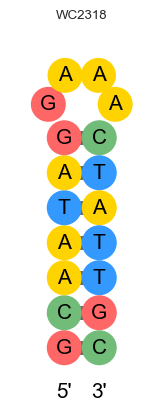

In [36]:
plotting.draw_target_struct('WC2318', arr)
util.save_fig('./fig/Fig2/Fig2a/UV_melting_example_curve_WC2318_struct.pdf')

# Direct comparison

In [37]:
def to_rgb(x):
    return np.array(x) / 256.

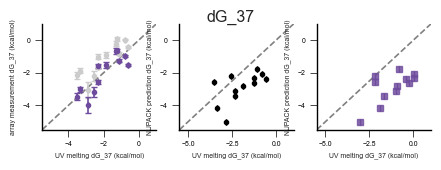

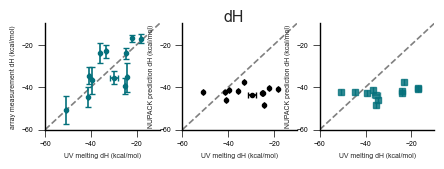

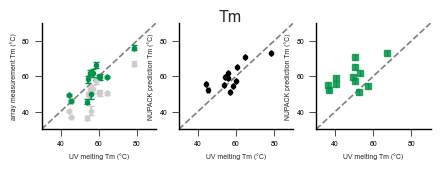

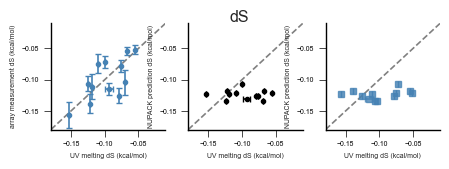

In [51]:
# for export
series = 'All'
plot_query = 'n_curve > 0'
df_q = vf.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q.dG_37_uv_std = 0

dTm = np.median(df_q.Tm_uv - df_q.Tm)
df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)
df_q['dH_adj'] = df_q.dH

def mae_norm(x, xerr, y):
    epsilon = 1e-2
    aerr = np.abs(x - y)
    return np.mean(aerr / (xerr + epsilon))

def plot_uv_comparison(df_q, param, lim, array_suffix='', plot_adj=False):
    unit_dict = dict(dH='kcal/mol', dS='kcal/mol', dG_37='kcal/mol', Tm='°C')
    color_dict = dict(dH=to_rgb([5,113,124]), Tm=to_rgb([0,148,71]), dG_37=to_rgb([110,75,158]), dS='steelblue')
    param_name_dict = dict(dH=r'$dH°$', dS=r'$dS°$', dG_37=r'$dG°_{37}$', Tm=r'$T_m$')
    unit = unit_dict[param]
    param_name = param_name_dict[param]
    
    kwargs = dict(fmt = '.', alpha=1, marker='o', markersize=3, capsize=2)
    
    fig, ax = plt.subplots(1, 3, figsize=(3*4.25*cm, 3.5*cm))
    for a in ax:
        a.tick_params(colors='k', width=.5)
        
    x = df_q[param + '_uv']
    y = df_q[param+array_suffix]
    
    xerr = df_q[param+'_uv_std'].values
    ax[0].plot(lim, lim, '--', c='gray')
    
    if plot_adj:
        y_adj = df_q[param+'_adj']
        ax[0].errorbar(x, y,
                       xerr=xerr, yerr=df_q[param+'_se'],
                       color=[.8]*3, **kwargs)
        ax[0].errorbar(x, y_adj,
                   xerr=xerr, yerr=df_q[param+'_se'],
                   color=color_dict[param], **kwargs)
    else:
        ax[0].errorbar(x, y,
                   xerr=xerr, yerr=df_q[param+'_se'],
                   color=color_dict[param], **kwargs)
        
    ax[0].set_xlim(lim)
    ax[0].set_ylim(lim)
    ax[0].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[0].set_ylabel(f'array measurement {param} ({unit})', fontsize=tick_font_size)
    # ax[0].set_title('Array Melt Measurement\ncorr = %.4f, MAE = %.4f' %
    #                 (pearsonr(x, y)[0], mae_norm(x, xerr, y)))
    
    if param == 'dG_37':
        ax[0].xaxis.set_major_locator(MultipleLocator(2))
        ax[0].yaxis.set_major_locator(MultipleLocator(2))
    
    x = df_q[param+'_uv'].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    ax[1].errorbar(x, y,
                   xerr=df_q[param+'_uv_std'],
                   color='k', **kwargs)
    ax[1].plot(lim, lim, '--', c='gray')
    ax[1].set_xlim(lim)
    ax[1].set_ylim(lim)
    ax[1].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[1].set_ylabel(f'NUPACK prediction {param} ({unit})', fontsize=tick_font_size)
    # ax[1].set_title('NUPACK prediction\ncorr = %.4f, MAE = %4f' %
    #                 (pearsonr(x, y)[0], mae_norm(x, xerr, y)))

    x = df_q[param+array_suffix].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    kwargs['marker'] = 's'
    kwargs['markersize'] = 5
    kwargs['alpha'] = 0.8
    ax[2].errorbar(x, y,
               xerr=df_q[param+'_uv_std'],
               color=color_dict[param], **kwargs)
    ax[2].plot(lim, lim, '--', c='gray')
    ax[2].set_xlim(lim)
    ax[2].set_ylim(lim)
    ax[2].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[2].set_ylabel(f'NUPACK prediction {param} ({unit})', fontsize=tick_font_size)
    # ax[2].set_title('Array Melt vs NUPACK prediction\ncorr = %.4f, MAE = %.4f' %
    #                 (pearsonr(x, y)[0], mae(x, y)))
    for i in range(3):
        ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=tick_font_size)
        ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=tick_font_size)

    plt.suptitle(param)
    sns.despine()
    # plt.show()
    
plot_uv_comparison(df_q, 'dG_37', lim = (-5.5, 1), plot_adj=True)
util.save_fig(f'./fig/Fig2/Fig2b/{series}_dG_37.pdf')
plot_uv_comparison(df_q, 'dH', lim = (-60, -10))
util.save_fig(f'./fig/Fig2/Fig2b/{series}_dH.pdf')
plot_uv_comparison(df_q, 'Tm', lim = (30, 90), plot_adj=True)
util.save_fig(f'./fig/Fig2/Fig2b/{series}_Tm.pdf')
plot_uv_comparison(df_q, 'dS', lim = (-.18, -.01))
util.save_fig(f'./fig/Fig2/Fig2b/{series}_dS.pdf')

In [43]:
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=1)
arr_adjusted = pd.read_csv('./data/models/processed/arr_v1_adjusted_n=27732.csv', index_col=0)

In [45]:
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr_adjusted, how='left', on='SEQID')
df_q = vf.dropna(subset=['Tm', 'dG_37'])

df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)
df_q['dH_adj'] = df_q.dH

In [53]:
pnames = ['dG_37', 'dH', 'Tm']
mae = [util.mae(df_q[p+'_uv'], df_q[p]) for p in pnames]
mae_adj = [util.mae(df_q[p+'_uv'], df_q[p+'_adj']) for p in pnames]

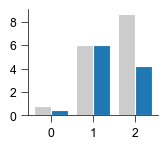

In [65]:
offset=.2
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
plt.bar(np.arange(3) - offset, mae, width = 0.4, color=[.8]*3)
plt.bar(np.arange(3) + offset, mae_adj, width = 0.4)
ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.tick_params(colors='k', width=.5)

sns.despine()
util.save_fig('./fig/Fig2/MAE_UV.pdf')